# A Quick Intro to BigQuery DataFrames

The Python module `bigframes` is an official package provided by Google, that presents a dataframe interface to interact with BigQuery data. This notebook contains a very brief intro on how to use the package, what it provides, what are some of its strengths and in which use cases you could consider using it.

In [1]:
import pandas as pd
import bigframes.pandas as bpd

## What does it mean?

BigQuery is the data warehouse solution provided by Google in its GCP offer. BigQuery is typically used via SQL, and the original package to be used from Python (`google-cloud-bigquery`) provides just that: a class that lets the user run arbitrary SQL code and returns the results as JSON-like objects (or Pandas DataFrames if the `to_pandas()` method is used).

BigQuery DataFrames (or `bigframes`) provides the same familiar interface from Pandas, but using BigQuery native objects. All the data (including local data) is stored in BigQuery, which is used as the computation backend for all operations performed by BigFrames. Even though the Pandas interface has not been mapped exactly 1:1, enough of it is implemented to provide a convincing illusion.

## Understanding `bigframes`

Throughout this notebook, we will be using the [NCAA Basketball dataset](https://console.cloud.google.com/marketplace/product/ncaa-bb-public/ncaa-basketball), which provides a wealth of data about college basketball teams, matches, etc. It is provided as a public dataset in BigQuery and can be added as a subscription straight away for any account. On of the tables included is the `mbb_pbp_sr` - a table containing play-by-play records. Let's load it using `bigframes`:

In [2]:
ncaa_pbp = bpd.read_gbq("bigquery-public-data.ncaa_basketball.mbb_pbp_sr")

`ncaa_pbp` is a BigQuery DataFrame object now, but **the cell above did close to nothing**. That is because `bigframes` provides a **lazy, symbolic interface**:
- **Lazy**, because no computation is performed if there is no need for it to happen. We have associated `ncaa_pbp` to a table, but since we have not asked for any computation, no data has been read yet.
- **Symbolic**, because laziness is a side effect of every method simply modifying the internal SQL code of each object. New filters and definitions simply add symbolic code, and only when a computation is required to present results (or define further symbolic definitions) the SQL code is actually executed.

You can actually check the SQL code for most of these objects:

In [3]:
print(ncaa_pbp.sql)

WITH t0 AS (
  SELECT
    t4.`game_id`,
    t4.`load_timestamp`,
    t4.`season`,
    t4.`status`,
    t4.`scheduled_date`,
    t4.`venue_id`,
    t4.`venue_name`,
    t4.`venue_city`,
    t4.`venue_state`,
    t4.`venue_address`,
    t4.`venue_zip`,
    t4.`venue_country`,
    t4.`venue_capacity`,
    t4.`attendance`,
    t4.`neutral_site`,
    t4.`conference_game`,
    t4.`tournament`,
    t4.`tournament_type`,
    t4.`round`,
    t4.`game_no`,
    t4.`away_market`,
    t4.`away_name`,
    t4.`away_id`,
    t4.`away_alias`,
    t4.`away_conf_name`,
    t4.`away_conf_alias`,
    t4.`away_division_name`,
    t4.`away_division_alias`,
    t4.`away_league_name`,
    t4.`home_market`,
    t4.`home_name`,
    t4.`home_id`,
    t4.`home_alias`,
    t4.`home_conf_name`,
    t4.`home_conf_alias`,
    t4.`home_division_name`,
    t4.`home_division_alias`,
    t4.`home_league_name`,
    t4.`period`,
    t4.`game_clock`,
    t4.`elapsed_time_sec`,
    t4.`possession_arrow`,
    t4.`team_name`,
 

Yes, it's not very readable, I know; I guess that it is not expected to be either. 

Notice what happens when we ask for the number of rows of the dataset:

In [4]:
print(f'There are {ncaa_pbp.shape[0]} rows')

There are 4160393 rows


We have traces of a job being executed to present us with this data, but it processed... No data? That is because **it took advantage of the underlying metadata**, and instead of scanning the ~3.5 GB of data included in the table, it simply took it from the pre-compute information that the data warehouse stores.

Something similar happens if we ask for the number of unique values:

In [5]:
ncaa_pbp[['game_id', 'team_id', 'player_id', 'event_id']].nunique()

/Users/dvicente/Projects/pydata-madrid-bigframes/.venv/lib/python3.11/site-packages/bigframes/core/blocks.py:126: NullIndexPreviewWarning: Creating object with Null Index. Null Index is a preview feature.
  warnings.warn(


game_id        11163
team_id          426
player_id      11889
event_id     3496530
dtype: Int64

However, try not to really too much on this laziness: sometimes, there are unexpected operations that require the computation to actually be performed, and this being BigQuery that can amount to a huge amount of data being scanned accidentally.

## Why should I use it?

There are some obvious situations and use cases where `bigframes` can be an interesting alternative to other ways to interface with BigQuery:
- You are using **Python as your main** tool for a project and need something to **bridge the gap with BigQuery**,
- You are **more comfortable with a Python + Pandas** workflow than using BigQuery's SQL, but you still need BigQuery as the data warehouse.

Does that mean that I should not be interested in `bigframes` if I am comfortable using SQL? Well, I would argue that there are some use cases where it can prove an interesting alternative:
- As a **substitute for SQL operations that are more cumbersome than its Pandas equivalent**,
- For EDA situations where some **plotting and visualization** is needed,
- For reporting and sharing insights in a notebook or HTML site, when **styling of the results is needed**,
- When a **remote function** is needed to process the data,
- When some **LLM functionality** is needed (`bigframes` provides a very convenient interface).

Let's take a look at some use cases to check these scenarios, in no particular order.

## Computing the player efficiency per shot

Using this play-by-play table, we could make a report on how each player performs per type of shot. We have several columns to do so:
- `team_alias` and `player_full_name`, which are the basic indexes we want to use for the aggregation,
- `event_type` which can be used to filter the categories of events we are interested in,
- `shot_type` and `shot_subtype` which provide information about the technique itself,
- `shot_made`, which marks whether the shot went in or not.

The first thing to do is to filter the data. This will feel extremely familiar to anyone who has used Pandas before (that's the whole point of it, isn't it?).

In [6]:
season = ncaa_pbp.loc[ncaa_pbp.season == 2017]

The next step is to create a new column that will serve as a top-level category for the type of shot, that will represent if it was a one, two, or three point shot (despite if it was or was not scored). Again, the syntax is the same as if we were using Pandas:

In [7]:
season['shot_for'] = 'N/A'
season.loc[season.event_type.str.startswith('freethrow'), 'shot_for'] = '1'
season.loc[season.event_type.str.startswith('twopoint'), 'shot_for'] = '2'
season.loc[season.event_type.str.startswith('threepoint'), 'shot_for'] = '3'

# Filter non-throw events
throws = season.loc[season.shot_for != 'N/A']

Before moving on, we also have to take care of some missing values in the `shot_type` and `shot_subtype` columns, since they have no value for free throws.

In [8]:
throws['shot_type'] = throws.shot_type.where(throws.shot_for != '1', 'free throw')
throws['shot_subtype'] = throws.shot_subtype.where(throws.shot_for != '1', 'free throw')

Now we can finally perform the analysis, again this is just about standard Pandas' workflow for computing this type of analysis: we group by player and shot type, compute the average of shots made and then unstack the indices that define the type of shot to turn these categories into individual columns. 

In [9]:
indices = ['team_alias', 'player_full_name']
columns = ['shot_for', 'shot_type', 'shot_subtype']

effectiveness = (
    throws
    .groupby(indices + columns)
    .agg({'shot_made': 'mean'})
    .rename(columns={'shot_made': 'effectiveness'})
    .unstack(columns)
)

Wait, **we just processed 3.4 GB of data, even though we didn't print any results yet?** Indeed, this is something to be very weary: since we are compiling to SQL, we still have to adhere to SQL rules to generate the query. In this case, the `unstack` operation cannot be compiled to its SQL equivalent (`PIVOT`) without explicitly listing the name of all columns. For that reason, `bigframes` is computing intermediate results to generate the symbolic representation of `effectiveness`. Understanding this is key, since we can easily run into unexpected scanning costs.

Let's now check the effectiveness of the 2017 season champions, the North Carolina Tar Heels.

In [10]:
(
    effectiveness.loc['UNC']
    .to_pandas()
    .sort_index(axis='columns')
)

effectiveness                                                \
                             1         2                                       
                    free throw      dunk                           hook shot   
                    free throw alley-oop driving   putback reverse   driving   
player_full_name                                                               
Aaron Rohlman              0.0      <NA>    <NA>      <NA>    <NA>      <NA>   
Andrew Platek              0.7      <NA>    <NA>      <NA>    <NA>      <NA>   
Brandon Huffman         0.5625      <NA>    <NA>       1.0    <NA>      <NA>   
Brandon Robinson      0.714286      <NA>    <NA>      <NA>    <NA>      <NA>   
Cameron Johnson       0.847458      <NA>     1.0      <NA>    <NA>      <NA>   
Garrison Brooks       0.587302       1.0    <NA>  0.666667    <NA>      <NA>   
Jalek Felton          0.666667      <NA>     1.0      <NA>    <NA>      <NA>   
Joel Berry II         0.892562      <NA>    <NA>      <NA>    <NA>      <NA>   
Kenny Williams        0.703704      <NA>    <NA>      <NA>    <NA>       1.0   
Luke Maye             0.623932      <NA>     0.0      <NA>    <NA>      <NA>   
Seventh Woods              0.8      <NA>    <NA>      <NA>    <NA>      <NA>   
Shea Rush                 <NA>      <NA>    <NA>      <NA>    <NA>      <NA>   
Sterling Manley       0.692308      <NA>     1.0       1.0    <NA>      <NA>   
Theo Pinson           0.818182      <NA>     1.0       1.0    <NA>      <NA>   
Walker Miller              1.0      <NA>    <NA>      <NA>    <NA>      <NA>   

                                                           ...            \
                                                           ...             
                            jump shot                      ...     layup   
                 turnaround   driving  fadeaway  floating  ... alley-oop   
player_full_name                                           ...             
Aaron Rohlman          <NA>      <NA>      <NA>      <NA>  ...      <NA>   
Andrew Platek          <NA>      <NA>      <NA>  0.666667  ...      <NA>   
Brandon Huffman         0.0      <NA>      <NA>      <NA>  ...      <NA>   
Brandon Robinson       <NA>      <NA>      <NA>       1.0  ...      <NA>   
Cameron Johnson        <NA>  0.333333      0.25  0.666667  ...      <NA>   
Garrison Brooks        <NA>      <NA>      0.75      <NA>  ...      <NA>   
Jalek Felton           <NA>      <NA>       0.0      <NA>  ...      <NA>   
Joel Berry II          <NA>      0.75       0.5  0.666667  ...      <NA>   
Kenny Williams         <NA>       0.0  0.666667  0.666667  ...       1.0   
Luke Maye              <NA>      <NA>  0.285714       0.0  ...     0.875   
Seventh Woods          <NA>      <NA>      <NA>      <NA>  ...      <NA>   
Shea Rush              <NA>      <NA>      <NA>      <NA>  ...      <NA>   
Sterling Manley         0.0      <NA>       0.0      <NA>  ...       0.0   
Theo Pinson            <NA>      <NA>      <NA>  0.285714  ...      <NA>   
Walker Miller          <NA>      <NA>      <NA>      <NA>  ...      <NA>   

                                                                             \
                                                                 3            
                                                         jump shot            
                   driving finger roll   putback reverse  fadeaway floating   
player_full_name                                                              
Aaron Rohlman          1.0        <NA>      <NA>    <NA>      <NA>     <NA>   
Andrew Platek     0.666667         1.0      <NA>    <NA>      <NA>     <NA>   
Brandon Huffman       <NA>        <NA>       1.0    <NA>      <NA>     <NA>   
Brandon Robinson       0.4        <NA>      <NA>    <NA>      <NA>     <NA>   
Cameron Johnson   0.666667        <NA>       1.0     1.0      <NA>     <NA>   
Garrison Brooks        1.0         1.0      0.75    <NA>      <NA>     <NA>   
Jalek Felton           0.0

These statistics look interesting, but they appear very hard to parse. Since we are using pandas on the client side (that is, once the computations on the data warehouse are done), we can apply a custom styler.

In [11]:
def format_effectiveness(styler):
    styler.set_caption("Effectiveness per shot type")
    styler.background_gradient(axis=None, vmin=-1, vmax=1, cmap="coolwarm")
    styler.format('{:.02%}', na_rep='-')
    styler.map(lambda x: 'color: transparent; background-color: white' if pd.isnull(x) else '')
    styler.set_table_styles([{"selector": "th", "props": [("border", "1px solid")]}])
    return styler


(
    effectiveness.loc['UNC']
    .to_pandas()
    .sort_index(axis='columns')
    .style.pipe(format_effectiveness)
)

Well that's something, right? We can easily check the performance of the whole team for the 2017 season at a glance. Not a great season for Shea Rush, but I'm sure he did great in defense.

Let's recap some of the takeaways of this example:
- Using `bigframes`, we can easily pivot tables. Doing so in SQL would require us to explicitly list each and every combination of `shot_type` and `shot_subtype`; in this case, `bigframes` does the heavy lifting for us.
- Apart from that, having the possibility of seamlessly stepping into the `pandas.Styler` functionalities allows us to generate very appealing reports in different formats, including HTML.

## Visualizing field goal attempts

The other area of analysis where Python clearly excels compared to SQL is visualization. SQL has no ready-interface for it, and everything ready for it relies on third-party implementations or plugins for dashboard or other languages. Even if `bigframes` is basically a package in the latter category, it will integrate our data with the wealth of Python packages for plotting, and for quick exploration it even features a `matplotlib` interface like the one pandas provides.

To test these visualization capabilities, let's try to take advantage of the columns `event_coord_x` and `event_coord_y` provided in the play-by-play and plot in a map all the shots performed during a given match.

First, let's convert the coordinates format to feet from the center circle.

In [12]:
season = ncaa_pbp.loc[ncaa_pbp.season == 2017]

In [13]:
season['event_feet_x'] = season.event_coord_x / 12 - 94/2
season['event_feet_y'] = season.event_coord_y / 12 - 50/2

Let's add a column that includes a basketball orange hex code if the shot was scored, and a light gray hex code if the shot was not made. The `bigframes` interface can contain color columns to be used when plotting.

In [14]:
season['shot_made_color'] = '#ee6730'
season['shot_made_color'] = season.shot_made_color.where(season.shot_made, '#b8b8b8')

Let's plot the data then:

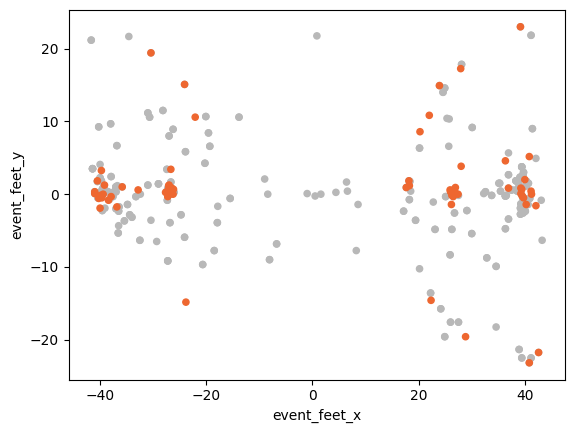

In [15]:
_ = (
    season
    .loc[season.game_id == '000872e5-f02a-4b64-ac73-b6b1a7ad10ec']
    .sort_values(by='shot_made')
    .plot(
        kind='scatter',
        x='event_feet_x',
        y='event_feet_y',
        c='shot_made_color'
    )
)

That was a very, very simple function call to handle all the plotting, but the results are a bit... bare. Let's try to improve it using a third-party package, [`sportypy`](https://github.com/sportsdataverse/sportypy), that will remove all the unused elements of the plot and add the court lines to better understand the distribution. This is how it looks when we define a white court and plot it with no data on top:

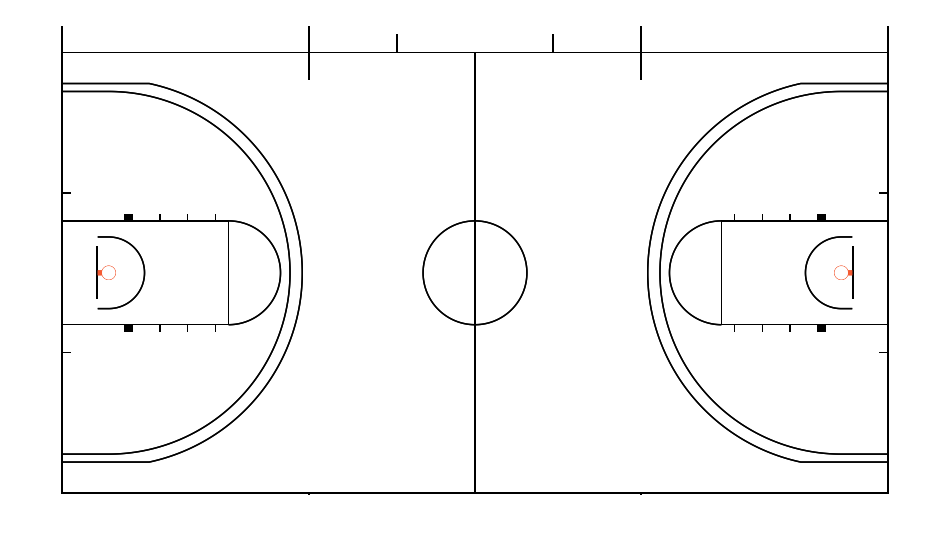

In [16]:
import matplotlib.pyplot as plt

from sportypy.surfaces.basketball import NCAACourt


fig, ax = plt.subplots(figsize=(12,12))

court = NCAACourt(
    color_updates={
        "plot_background": "white",
        "defensive_half_court": "white",
        "offensive_half_court": "white",
        "court_apron": "white",
        "center_circle_fill": "white",
        "two_point_range": ["white", "white"],
        "painted_area": "white",
        "free_throw_circle_fill": "white",
    }
)

_ = court.draw(ax=ax)

Nice! Let's put everything together. Following the indications of the `sportypy` package, we have to use a z-order larger than 20 for the data to be on top. Let's add that keyword argument to the `.plot()` call so that it gets to the `matplotlib` backend.

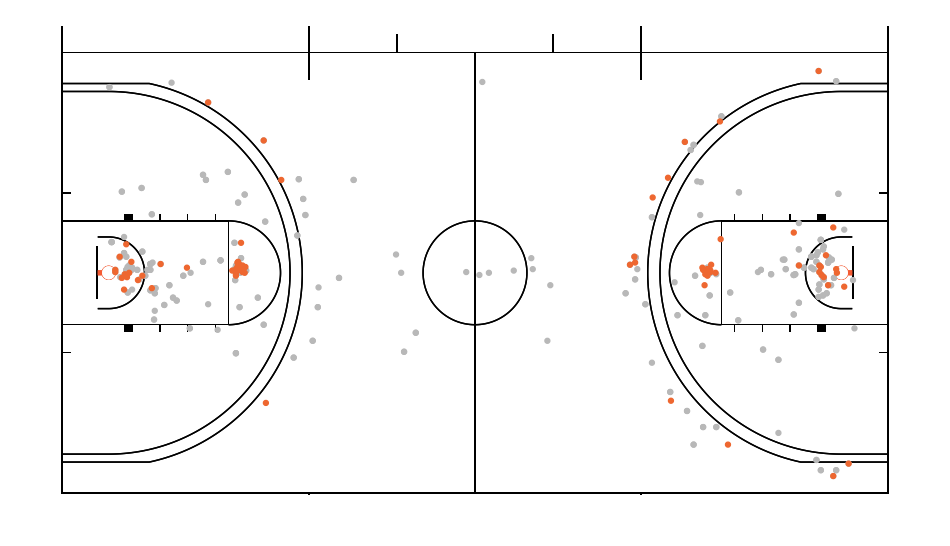

In [17]:
ax = (
    season
    .loc[season.game_id == '000872e5-f02a-4b64-ac73-b6b1a7ad10ec']
    .sort_values(by='shot_made')
    .plot(
        kind='scatter',
        x='event_feet_x',
        y='event_feet_y',
        c='shot_made_color',
        s=12.5,
        zorder=30,
        figsize=(12,12),
    )
)

_ = court.draw(ax=ax)

And we're done! This was certainly easier, and being able to quickly iterate without having to worry about moving the data allowed us to get this done much faster than expected. The result is also more appealing than probably any tool available to plot BigQuery data out there, thanks to the ability of including arbitrary third party packages.

## Using LLMs to generate match commentary

Using Gemini models to generate brief match commentary allows us to showcase two of the most impressive features of the package: easy remote functions and LLM integration in a `sklearn`-like interface. First, we need to read a different table, `bigquery-public-data.ncaa_basketball.mbb_games_sr`, which contains one record per match and includes statistics for each of the teams. If we format this information properly, we can pass it to an LLM to generate the text.

In [18]:
matches = bpd.read_gbq("bigquery-public-data.ncaa_basketball.mbb_games_sr")

Now we need to format the records into a natural language string so that the LLM has context to generate the commentary. We could abuse the `str.concat` functions to get something, but we could not use conditionals on that code. Instead, let's create a Python function that will make use of f-strings and other string formatting goodies to generate a very complex format:

In [19]:
@bpd.remote_function(bpd.Series, str, reuse=True)
def match_summary(row):
    # General match facts:
    heading = "# {home} ({h_alias}) vs {away} ({a_alias}) - {date}\n\n".format(
        home = row.h_name,
        h_alias = row.h_alias,
        away = row.a_name,
        a_alias = row.a_alias,
        date = row.scheduled_date,
    )

    general = [
        "## General info",
        # Venue and attendance
        "- Played @ {venue} ({state}), attendance of {att} ({att_pc:.02%})".format(
            venue = row.venue_name,
            state = row.venue_state,
            att = row.attendance,
            att_pc = row.attendance / row.venue_capacity,
        ),
        # Ranks
        "- Rank: {home} = #{home_rank}; {away} = #{away_rank}".format(
            home = row.h_alias,
            home_rank = row.h_rank or "N/A",
            away = row.a_alias,
            away_rank = row.a_rank or "N/A",
        )
    ]
    
    if row.notnull().tournament:
        general.append(
            "- {tournament} {type} - {round} {game_no}".format(
                tournament = row.tournament,
                type = row.tournament_type,
                round = row.tournament_round,
                game_no = row.tournament_game_no,
            )
        )

    statistics = [
        "## Statistics",
        "First item is for the home team ({home}), second for the away team ({away}).".format(
            home=row.h_alias,
            away=row.a_alias,
        ),
        f"- Total Points: {row.h_points_game} - {row.a_points_game}",
        f"- FG: {row.h_field_goals_made} ({row.h_field_goals_pct}%) - {row.a_field_goals_made} ({row.a_field_goals_pct}%)",
        f"- 3FG: {row.h_three_points_made} ({row.h_three_points_pct}%) - {row.a_three_points_made} ({row.a_three_points_pct}%)",
        f"- ORB: {row.h_offensive_rebounds} - {row.a_offensive_rebounds}",
        f"- DRB: {row.h_defensive_rebounds} - {row.a_defensive_rebounds}",
        f"- AST: {row.h_assists} - {row.a_assists}",
        f"- STL: {row.h_steals} - {row.a_steals}",
        f"- BLK: {row.h_blocks} - {row.a_blocks}",
        f"- TOV: {row.h_turnovers} - {row.a_turnovers}",
        f"- PF: {row.h_personal_fouls} - {row.a_personal_fouls}",
    ]

    return heading + '\n'.join(general) + '\n\n' + '\n'.join(statistics) 

/Users/dvicente/Projects/pydata-madrid-bigframes/.venv/lib/python3.11/site-packages/bigframes/functions/remote_function.py:948: PreviewWarning: input_types=Series is in preview.
  warnings.warn(


How will we run this Python code on our data, anyway? This symbol is evaluated on our local Python session, but the data is still living on BigQuery. Will a `.apply(match_summary, axis=1)` download all of the data to our local machine?

The main thing going on is the decorator: `@bpd.remote_function` is taking this callable and **deploying the function as a remote function in GCP**, making it available to be called from BigQuery and therefore, natively for `bigframes`. To further appreciate the amount of boilerplate this just saved us, the decorator just:
1. Wrapped the callable into a web server, using the `functions_framework` package,
2. Defined the endpoints and plugged it into our callable,
3. Found out any dependencies and deployed them alongside our function in a remote function container,
4. Linked the local callable with the remote function ID so that `.apply(match_summary, axis=1)` works in both Pandas and BigQuery DataFrames in the current session.

There are some caveats though:
- As you can see, applying it to a DataFrame and receiving a `bpd.Series` as an argument is a preview function,
- No timestamp or date columns can be passed in that `bpd.Series`.

Let's remove the timestamp column (we don't need them) and format the date column as a string:

In [20]:
matches = matches.drop(columns=["created", "gametime"])

matches["scheduled_date"] = matches.scheduled_date.dt.strftime("%Y-%m-%d")

Now we can put everything together and add a new column, `summary`, with the formatted information for all matches.

In [21]:
matches["summary"] = matches.apply(match_summary, axis=1)

print(
    matches
    .loc[matches.game_id == '000872e5-f02a-4b64-ac73-b6b1a7ad10ec']
    .summary.iloc[0]
)

/Users/dvicente/Projects/pydata-madrid-bigframes/.venv/lib/python3.11/site-packages/bigframes/dataframe.py:3371: PreviewWarning: axis=1 scenario is in preview.
  warnings.warn(


/Users/dvicente/Projects/pydata-madrid-bigframes/.venv/lib/python3.11/site-packages/bigframes/core/__init__.py:108: PreviewWarning: Interpreting JSON column(s) as StringDtype. This behavior may change in future versions.
  warnings.warn(


# Gators (FLA) vs Bulldogs (UGA) - 2018-02-15

## General info
- Played @ Exactech Arena at the Stephen C. O'Connell Center (FL), attendance of 9497 (93.72%)
- Rank: FLA = #N/A; UGA = #N/A

## Statistics
First item is for the home team (FLA), second for the away team (UGA).
- Total Points: 69 - 72
- FG: 22 (37.9%) - 24 (42.1%)
- 3FG: 9 (40.9%) - 6 (33.3%)
- ORB: 10 - 12
- DRB: 23 - 30
- AST: 10 - 9
- STL: 6 - 3
- BLK: 2 - 5
- TOV: 9 - 13
- PF: 24 - 22


This summary is rough to read, but should be enough context for the LLM to generate the comments. To actually call it, we can use the built-in class `GeminiTextGenerator` — if your BigQuery project has a connection already, it will be inferred from it and no further configuration for the class will be needed.

In [22]:
from bigframes.ml.llm import GeminiTextGenerator

model = GeminiTextGenerator()

Now we can simply add a prompt instructing the LLM what to do and call `predict` on it. In case you are wondering, yes - there is also a `fit` method that will fine-tune the model (if the model accepts such behavior). Let's generate the commentary for all matches in which the Gators have been involved, and include them back in the original DataFrame as a column.

In [23]:
prompt = (
    "Use the following statistics to generate a chronicle for the following basketball "
    "match. Stick to the stats, don't make things up. Be concise, it should fit in a tweet:\n"
)

subset = matches.loc[(matches.h_alias == 'UGA') | (matches.a_alias == 'UGA')]

chronicles = model.predict(prompt + subset.summary, max_output_tokens=512)
subset['chronicle'] = chronicles.ml_generate_text_llm_result

/Users/dvicente/Projects/pydata-madrid-bigframes/.venv/lib/python3.11/site-packages/bigframes/core/__init__.py:108: PreviewWarning: Interpreting JSON column(s) as StringDtype. This behavior may change in future versions.
  warnings.warn(


In [24]:
print(
    subset
    .loc[subset.game_id == '000872e5-f02a-4b64-ac73-b6b1a7ad10ec']
    .chronicle.iloc[0]
)

🚨 Close game at the O'Connell Center! Despite shooting better from the field and behind the arc, the Gators fall to the Bulldogs 69-72. The Dawgs outrebounded Florida 42-33 and got to the line more, shooting 13 free throws to Florida's 9. #GoGators #BeatUGA 🏀 📊


Would you look at that, Gemini seems to be a Gators supporter! Remember to be more specific in your prompt than I was, or you may find yourself with commentary that always supports the home team despite the result.

## Conclusions

So, should you be using `bigframes`? I hope that after this quick demo, you have a more in-depth understanding of its strong points:
- Reporting that requires **advanced styling and graphing**,
- **Integrating third-party Python code** in your analysis,
- Complex functions that are cumbersome in SQL syntax and can be implemented in **remote functions**.

However, there are some cons:
- It is **not the fastest option**: the symbolic computation does not cache as much as one could expect and can re-compute the same thing several times.
- It is a **massive abstraction that leaks occasionally**, making it dangerous when dealing with huge amounts of data.
- If you are comfortable with SQL, using `google.cloud.bigquery` and then exporting the results to Pandas explicitly can be more predictable, albeit more cumbersome.

## Further literature

If you want to see how to apply `bigframes` to a real-life scenario that uses huge amounts of data and integrating CARTO for visualization with of cloud data within a Jupyter Notebook, check out [**_Build maps in the cloud with BigQuery DataFrames, Gemini, and CARTO_** by Giulia Carella][1].

[1]: https://cloud.google.com/blog/products/data-analytics/using-bigquery-dataframes-with-carto-geospatial-tools